# Fixed probe station location study
This script locates the fixed probe stations' azimuthal locations in the trolley basis.
It uses the trolley footrpint study performed by S. Corrodi at the ANL test magnet.
[Link to study.](https://muon.npl.washington.edu/elog/g2/General+Field+Team/1309)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.optimize

import gm2
import trfp

deg_per_mm = 360./(2.*np.pi*7112.)

Welcome to JupyROOT 6.12/04


## Simon's study


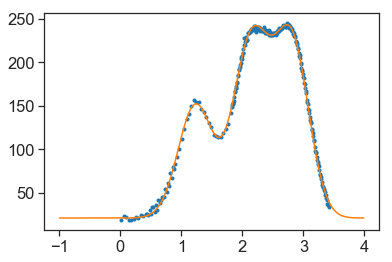

In [2]:
# Load ANL trolley footprint study
footprint = np.loadtxt('trolley_magnetic_footprint.dat')
footprint = np.transpose(footprint)
footprint[:,0] *= deg_per_mm

# fit a triple Gaussian shape to this

# drop the first part of the data to ignore the leading "little bump"
footprint = footprint[footprint[:,0]>=0]

def _gaussian(x, A, x0, s): return A * np.exp(-(x-x0)**2/(2*s**2))


def footprint_model(x, A1, A2, A3, x01, x02, x03, s1, s2, s3, C):
    return _gaussian(x, A1, x01, s1) + _gaussian(x, A2, x02, s2) + _gaussian(x, A3, x03, s3) + C

c, covar = scipy.optimize.curve_fit(footprint_model, footprint[:,0], footprint[:,1],
                                    p0=[125, 225, 225, 1.25, 2, 2.75, .25, .25, .25, 25])

c, covar = scipy.optimize.curve_fit(footprint_model, footprint[:,0], footprint[:,1], p0=c)


plt.plot(footprint[:,0], footprint[:,1], '.')
plt.plot(np.arange(-1, 4, 0.01),
         footprint_model(np.arange(-1, 4, 0.01), c[0], c[1], c[2], c[3], c[4], c[5], c[6], c[7], c[8], c[9]))

# using the fit parameters above, define a trolley footprint model

def trolley_effect(x, C, A, x0):
    y = footprint_model(x-x0, c[0], c[1], c[2], c[3], c[4], c[5], c[6], c[7], c[8], c[9])
    y -= c[9]
    y *= A/np.max(y)
    return y + C

In [6]:
run = trfp.Run(3956)

Trolley run.
Reading event 8780/8781 99.99%           
loop done: 100%                                    
Reading event 2630/2634 99.85%    
loop done: 100%                                    
Interpolating trolley position.
Interpolating trolley frequencies.
Interpolating fixed probe frequencies.
Finished calculating all moments for 4382 events.


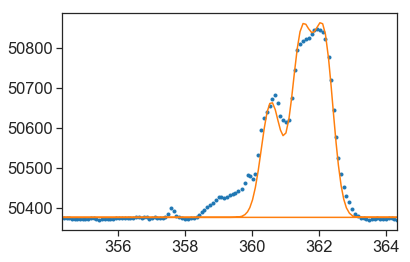




[350.169, 354.321, 359.324, 4.326, 9.32, 14.343, 20.192, 23.318, 29.335, 34.354, 39.338, 43.33, 50.188, 53.314, 59.379, 64.336, 69.363, 73.341, 80.163, 83.315, 89.321, 94.325, 99.302, 103.296, 110.17, 113.321, 119.335, 124.316, 129.309, 133.258, 140.204, 143.381, 149.366, 154.326, 159.355, 163.302, 170.174, 173.328, 179.375, 184.343, 189.363, 193.317, 200.171, 203.385, 209.34, 214.332, 219.335, 223.317, 230.223, 233.42, 239.366, 244.336, 249.377, 253.33, 260.206, 263.461, 269.366, 274.4, 279.395, 283.422, 290.191, 293.377, 299.346, 304.323, 309.311, 313.292, 320.187, 323.396, 329.328, 334.347, 339.344, 343.405]


In [9]:
# time to fit the stations

station_ring_phi = np.zeros(72)

station_to_plot = 2

for st in np.arange(72):
    label = 'st'+str(st)+',m1'

    x = run.moment_df['tr_phi'].copy()
    y = run.moment_df[label].copy()

    p0 = (np.median(y),np.max(y)-np.median(y),trfp.STATION_RING_PHI[st])

    bounds = ((np.min(y), 0.5*(np.max(y)-np.min(y)), trfp.STATION_RING_PHI[st]-10),
              (np.max(y), 1.5*(np.max(y)-np.min(y)), trfp.STATION_RING_PHI[st]+10))
    
    # get naive fit
    (coeffs, covars) = scipy.optimize.curve_fit(trolley_effect, x, y, p0=p0, bounds=bounds)
    
    # use naive fit to narrow down the x limits for the fit
    
    if coeffs[2] < 360-3.5:
        mask = (x>coeffs[2]) & (x<coeffs[2]+3.5)
    else:
        mask = (x>coeffs[2]) | (x<coeffs[2]+3.5)
    if st == 2: x[x<300] += 360
    if st == 3: x[x>300] -= 360
    x = x[mask]
    y = y[mask]
    
    (coeffs, covars) = scipy.optimize.curve_fit(trolley_effect, x, y, p0=coeffs, bounds=bounds)
    
    station_ring_phi[st] = coeffs[2]
    
    if st == station_to_plot:
        y_fit = trolley_effect(x,coeffs[0],coeffs[1],coeffs[2])
        plt.plot(x,y,'.',x,y_fit)
        plt.xlim(coeffs[2]-5,coeffs[2]+5)
        plt.show()
print "\n\n"        
print list(np.round(station_ring_phi, 3))

In [11]:
run2 = trfp.Run(3997)

Trolley run.
Reading event 8730/8735 99.94%       
loop done: 100%                                    
Reading event 2610/2619 99.66%      
loop done: 100%                                    
Interpolating trolley position.
Interpolating trolley frequencies.
Interpolating fixed probe frequencies.
Finished calculating all moments for 4359 events.


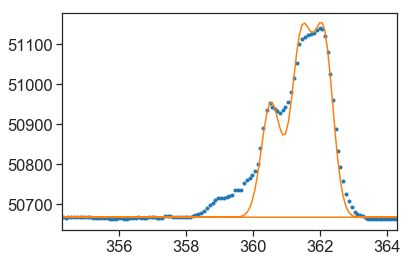




[350.166, 354.346, 359.314, 4.325, 9.316, 14.321, 20.169, 23.323, 29.271, 34.35, 39.369, 43.276, 50.185, 53.308, 59.361, 64.34, 69.343, 73.315, 80.195, 83.308, 89.315, 94.354, 99.147, 103.316, 110.181, 113.309, 119.337, 124.287, 129.303, 133.065, 140.197, 143.376, 149.349, 154.335, 159.333, 163.305, 170.141, 173.269, 179.336, 184.327, 189.363, 193.316, 200.103, 203.379, 209.266, 214.33, 219.207, 223.274, 230.221, 233.41, 239.346, 244.339, 249.38, 253.3, 260.189, 263.454, 269.327, 274.413, 279.348, 283.417, 290.193, 293.375, 299.307, 304.316, 309.291, 313.282, 320.174, 323.241, 329.301, 334.35, 339.381, 343.332]


In [12]:
station_ring_phi = np.zeros(72)

station_to_plot = 2

for st in np.arange(72):
    label = 'st'+str(st)+',m1'

    x = run2.moment_df['tr_phi'].copy()
    y = run2.moment_df[label].copy()

    p0 = (np.median(y),np.max(y)-np.median(y),trfp.STATION_RING_PHI[st])

    bounds = ((np.min(y), 0.5*(np.max(y)-np.min(y)), trfp.STATION_RING_PHI[st]-10),
              (np.max(y), 1.5*(np.max(y)-np.min(y)), trfp.STATION_RING_PHI[st]+10))
    
    (coeffs, covars) = scipy.optimize.curve_fit(trolley_effect, x, y, p0=p0, bounds=bounds)
    
    # use naive fit to narrow down the x limits for the fit
    
    if coeffs[2] < 360-3.5:
        mask = (x>coeffs[2]) & (x<coeffs[2]+3.5)
    else:
        mask = (x>coeffs[2]) | (x<coeffs[2]+3.5)
    if st == 2: x[x<300] += 360
    if st == 3: x[x>300] -= 360
    x = x[mask]
    y = y[mask]
    
    (coeffs, covars) = scipy.optimize.curve_fit(trolley_effect, x, y, p0=coeffs, bounds=bounds)
    
    station_ring_phi[st] = coeffs[2]
    
    if st == station_to_plot:
        y_fit = trolley_effect(x,coeffs[0],coeffs[1],coeffs[2])
        plt.plot(x,y,'.',x,y_fit)
        plt.xlim(coeffs[2]-5,coeffs[2]+5)
        plt.show()
print "\n\n"        
print list(np.round(station_ring_phi, 3))

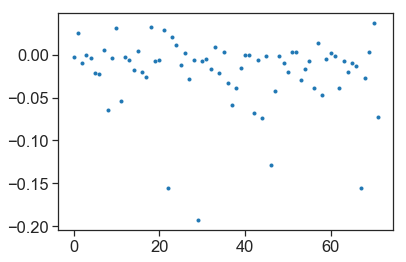

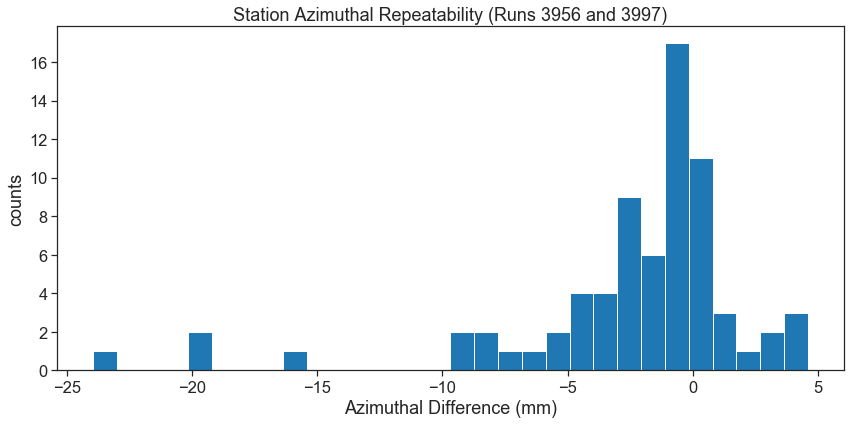

In [14]:
list3956 = np.array([350.167, 354.32, 358.814, 4.324, 9.318, 14.343, 20.191, 23.315, 29.333, 34.352, 39.335, 43.328, 50.188, 53.312, 59.375, 64.334, 69.361, 73.338, 80.16, 83.314, 89.318, 94.325, 99.297, 103.295, 110.171, 113.32, 119.333, 124.315, 129.306, 133.26, 140.204, 143.379, 149.365, 154.324, 159.354, 163.301, 170.174, 173.327, 179.374, 184.341, 189.363, 193.315, 200.172, 203.384, 209.342, 214.329, 219.331, 223.316, 230.222, 233.415, 239.361, 244.334, 249.377, 253.325, 260.218, 263.46, 269.364, 274.399, 279.392, 283.418, 290.189, 293.376, 299.344, 304.321, 309.309, 313.29, 320.185, 323.395, 329.326, 334.348, 339.342, 343.404])
list3956new = np.array([350.169, 354.321, 359.324, 4.326, 9.32, 14.343, 20.192, 23.318, 29.335, 34.354, 39.338, 43.33, 50.188, 53.314, 59.379, 64.336, 69.363, 73.341, 80.163, 83.315, 89.321, 94.325, 99.302, 103.296, 110.17, 113.321, 119.335, 124.316, 129.309, 133.258, 140.204, 143.381, 149.366, 154.326, 159.355, 163.302, 170.174, 173.328, 179.375, 184.343, 189.363, 193.317, 200.171, 203.385, 209.34, 214.332, 219.335, 223.317, 230.223, 233.42, 239.366, 244.336, 249.377, 253.33, 260.206, 263.461, 269.366, 274.4, 279.395, 283.422, 290.191, 293.377, 299.346, 304.323, 309.311, 313.292, 320.187, 323.396, 329.328, 334.347, 339.344, 343.405])
list3997 = np.array([350.164, 354.345, 358.849, 4.323, 9.313, 14.321, 20.167, 23.321, 29.268, 34.347, 39.364, 43.273, 50.183, 53.306, 59.356, 64.339, 69.341, 73.315, 80.192, 83.306, 89.312, 94.354, 99.141, 103.313, 110.183, 113.304, 119.337, 124.286, 129.303, 133.063, 140.195, 143.376, 149.347, 154.332, 159.332, 163.305, 170.145, 173.266, 179.338, 184.326, 189.363, 193.315, 200.109, 203.378, 209.264, 214.326, 219.192, 223.267, 230.223, 233.403, 239.338, 244.333, 249.38, 253.291, 260.197, 263.452, 269.325, 274.411, 279.345, 283.412, 290.189, 293.373, 299.306, 304.315, 309.29, 313.279, 320.172, 323.241, 329.298, 334.35, 339.38, 343.33])
list3997new = np.array([350.166, 354.346, 359.314, 4.325, 9.316, 14.321, 20.169, 23.323, 29.271, 34.35, 39.369, 43.276, 50.185, 53.308, 59.361, 64.34, 69.343, 73.315, 80.195, 83.308, 89.315, 94.354, 99.147, 103.316, 110.181, 113.309, 119.337, 124.287, 129.303, 133.065, 140.197, 143.376, 149.349, 154.335, 159.333, 163.305, 170.141, 173.269, 179.336, 184.327, 189.363, 193.316, 200.103, 203.379, 209.266, 214.33, 219.207, 223.274, 230.221, 233.41, 239.346, 244.339, 249.38, 253.3, 260.189, 263.454, 269.327, 274.413, 279.348, 283.417, 290.193, 293.375, 299.307, 304.316, 309.291, 313.282, 320.174, 323.241, 329.301, 334.35, 339.381, 343.332])

list_diffs = list3997new - list3956new

plt.plot(list_diffs, '.')

fig, ax = plt.subplots(1,1)
plt.hist(list_diffs/deg_per_mm, bins=30)
plt.xlabel('Azimuthal Difference (mm)')
plt.title('Station Azimuthal Repeatability (Runs 3956 and 3997)')
plt.ylabel('counts')
fig.set_size_inches(12,6)
fig.tight_layout()

In [ ]:
print station_ring_phi
print '\n'
print station_ring_phi-trfp.STATION_RING_PHI

In [ ]:
x1 = np.array([350.17685631, 354.30406708, 358.83623806, 4.35240544, 9.32206272
, 14.20303035, 20.20399984, 23.31454619, 29.32704948, 34.33090375
, 39.33314149, 43.31186448, 50.20790264, 53.31372932, 59.34344047
, 64.31571127, 69.3447512, 73.29678754, 80.15567847, 83.32465393
, 89.30462637, 94.312144, 99.30329035, 103.30144532, 110.19012489
, 113.31473486, 119.33139431, 124.31805867, 129.30248023, 133.26492222
, 140.20506912, 143.37866634, 149.35650273, 154.33030655, 159.35134591
, 163.30280959, 170.17258808, 173.37578725, 179.37086803, 184.34860116
, 189.35874727, 193.31203033, 200.17397531, 203.38743279, 209.34640381
, 214.31348996, 219.33820433, 223.31708302, 230.22539407, 233.41646226
, 239.35416455, 244.33504266, 249.3766332, 253.34497409, 260.21109934
, 263.46900851, 269.35210197, 274.34318626, 279.3735428, 283.41452811
, 290.17557338, 293.37088886, 299.33322785, 304.32034054, 309.33729456
, 313.29371942, 320.18673347, 323.41222932, 329.32848823, 334.34625774
, 339.34548139, 343.40617345])

x2 = np.array([350.17240943, 354.34820922, 358.83396603, 4.33699416, 9.32859981
, 14.25245337, 20.20486029, 23.32400696, 29.32688629, 34.33315183
, 39.33644653, 43.30444831, 50.19159463, 53.31358289, 59.3287227
, 64.34107629, 69.33861661, 73.3023333, 80.18108822, 83.31710966
, 89.31049552, 94.34376604, 99.31746476, 103.29782323, 110.18852972
, 113.30260946, 119.33934967, 124.32733139, 129.30398564, 133.27274034
, 140.20983136, 143.37555541, 149.32822406, 154.32833527, 159.36288459
, 163.31693923, 170.2095447, 173.39884053, 179.35802611, 184.34843557
, 189.35584984, 193.31109049, 200.16749673, 203.38067579, 209.34030038
, 214.31431814, 219.33479797, 223.32315712, 230.2171529, 233.42389423
, 239.35826272, 244.33547348, 249.3739451, 253.33248402, 260.18351555
, 263.46357302, 269.35676154, 274.34243806, 279.37853235, 283.40381883
, 290.20307161, 293.37596783, 299.34781249, 304.29364539, 309.33899488
, 313.29212657, 320.1994366, 323.41448133, 329.32483805, 334.35134602
, 339.35314171, 343.41381479])

out = np.round((x1+x2)/2,2)

In [ ]:
## DEPRECATED

# def trolley_effect(x, B0, A, x0):
#     # x0 needs to be in deg, not mm
#     # 2*pi*7112/360 mm per deg
#     deg_per_mm = 360./(2.*np.pi*7112.)
#     return (B0 + A * ((131./204.)*np.exp(-(x-x0-153*deg_per_mm)**2/(2*25.6*deg_per_mm)**2)
#                       + np.exp(-(x-x0-266*deg_per_mm)**2/(2*25.7*deg_per_mm)**2)
#                       + np.exp(-(x-x0-348*deg_per_mm)**2/(2*25*deg_per_mm)**2)))